## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import math
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

## Загрузка данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile

with ZipFile("drive/MyDrive/Machine Learning projects/Playground Series/Season 3, Episode 22/playground-series-s3e22.zip") as myzip:
    train = myzip.open("train.csv")
    test = myzip.open("test.csv")
    submission = myzip.open("sample_submission.csv")
train = pd.read_csv(train, na_values="None")
test = pd.read_csv(test, na_values="None")
submission = pd.read_csv(submission)

## Разведочный анализ данных

### Функции для визуализации данных

In [4]:
def plot_cat_features(data, features:list, target:str, NCOLS:int):

    NROWS = math.ceil(len(features) / NCOLS)
    fig, ax = plt.subplots(NROWS, NCOLS, figsize=(20,40))
    ax = ax.flatten()

    for i, col in enumerate(features):

        sns.countplot(data=data, x=col,
                    ax=ax[i], hue=data[target], palette="YlOrRd")
        ax[i].legend(loc = 'upper right')
        ax[i].set_ylabel('')
    fig.suptitle(f'Распределение категориальных признаков\n\n\n\n', ha='center',  fontweight='bold', fontsize=25)
    plt.tight_layout() # уменьшает зазор между названием графика и самим графиком


    return

In [5]:
def plot_num_features(train_df, test_df, features:list, NCOLS:int):

    NROWS = math.ceil(len(features) / NCOLS)
    fig, ax = plt.subplots(NROWS, NCOLS, figsize=(20,30))
    ax = ax.flatten() # вытягиваем ax в одномерный массив, чтобы не бежать по циклу отдельно по строкам и столбцам

    for i, col in enumerate(features):

        sns.kdeplot(data=train_df, x=train_df[col],
                    ax=ax[i], color=color_pal[0])

        sns.kdeplot(data=train_df, x=test_df[col],
                    ax=ax[i], color=color_pal[1])

        ax[i].set_ylabel('')
        ax[i].legend(['Train', 'Test'])

    fig.suptitle(f'Распределение числовых признаков\n\n\n\n', ha='center',  fontweight='bold', fontsize=25)
    plt.tight_layout() # уменьшает зазор между названием графика и самим графиком

    return


In [ ]:
def boxplot_num_features(train_df, features:list, NCOLS:int):

    NROWS = math.ceil(len(features) / NCOLS)
    fig, ax = plt.subplots(NROWS, NCOLS, figsize=(20,30))
    ax = ax.flatten() # вытягиваем ax в одномерный массив, чтобы не бежать по циклу отдельно по строкам и столбцам

    for i, col in enumerate(features):

        sns.boxplot(data=train_df,
                    x=target,
                    y=train_df[col],
                    orient='v',
                    ax=ax[i])

        ax[i].set_ylabel('')
        ax[i].set_xlabel(col)

    fig.suptitle(f'Распределение числовых признаков в зависимости от таргета\n\n\n\n', ha='center',  fontweight='bold', fontsize=25)
    # plt.tight_layout() # уменьшает зазор между названием графика и самим графиком

    return


### Разделение признаков на категориальные и числовые

Посмотрим на данные

In [ ]:
train.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,NaN,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,NaN,3.5,NaN,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,NaN,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [6]:
def info(df):
    print(f'размер датасета: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['data_type'])
    summary['missing_counts'] = df.isnull().sum()
    summary['%_missing'] = df.isnull().sum() / df.shape[0] * 100
    summary['number_of_unique'] = df.nunique()
    desc = df.describe(include = 'all').T



    summary['max'] = desc['max']
    summary['min'] = desc['min']
    summary['std'] = desc['std']
    # except:
    #     summary['max'] = "Category"
    #     summary['min'] = "Category"
    #     summary['std'] = "Category"
      # print('Все признаки категориальные')

    # summary['top'] = desc['top']
    summary['first_value'] = df.loc[0]

    return summary.sort_values(by='%_missing', ascending=False)

In [ ]:
info(train)

размер датасета: (1235, 29)


,data_type,missing_counts,%_missing,number_of_unique,max,min,std,top,first_value
abdomen,object,213,17.246964,5,NaN,NaN,NaN,distend_small,distend_small
rectal_exam_feces,object,190,15.384615,5,NaN,NaN,NaN,absent,decreased
nasogastric_tube,object,80,6.477733,3,NaN,NaN,NaN,slight,slight
peripheral_pulse,object,60,4.858300,4,NaN,NaN,NaN,reduced,reduced
abdomo_appearance,object,48,3.886640,3,NaN,NaN,NaN,serosanguious,serosanguious
pain,object,44,3.562753,6,NaN,NaN,NaN,depressed,depressed
temp_of_extremities,object,39,3.157895,4,NaN,NaN,NaN,cool,cool
abdominal_distention,object,23,1.862348,4,NaN,NaN,NaN,moderate,slight
nasogastric_reflux,object,21,1.700405,4,NaN,NaN,NaN,more_1_liter,less_1_liter
mucous_membrane,object,21,1.700405,6,NaN,NaN,NaN,pale_pink,dark_cyanotic


In [ ]:
info(test)

размер датасета: (824, 28)


,data_type,missing_counts,%_missing,number_of_unique,max,min,std,top,first_value
abdomen,object,154,18.689320,5,NaN,NaN,NaN,distend_small,distend_small
rectal_exam_feces,object,125,15.169903,4,NaN,NaN,NaN,absent,normal
nasogastric_tube,object,64,7.766990,3,NaN,NaN,NaN,slight,none
peripheral_pulse,object,47,5.703883,4,NaN,NaN,NaN,reduced,normal
temp_of_extremities,object,35,4.247573,4,NaN,NaN,NaN,cool,normal
abdomo_appearance,object,31,3.762136,3,NaN,NaN,NaN,serosanguious,clear
pain,object,29,3.519417,6,NaN,NaN,NaN,depressed,mild_pain
abdominal_distention,object,22,2.669903,4,NaN,NaN,NaN,moderate,slight
peristalsis,object,19,2.305825,4,NaN,NaN,NaN,hypomotile,hypomotile
nasogastric_reflux,object,14,1.699029,3,NaN,NaN,NaN,more_1_liter,none


Задача предсказать судьбу лошади (***outcome***) по его медицинским характеристикам. Задача многоклассовой классификации
Стоит отметить, что в данных присутствуют пропуски

Разделим признаки на категориальные и числовые

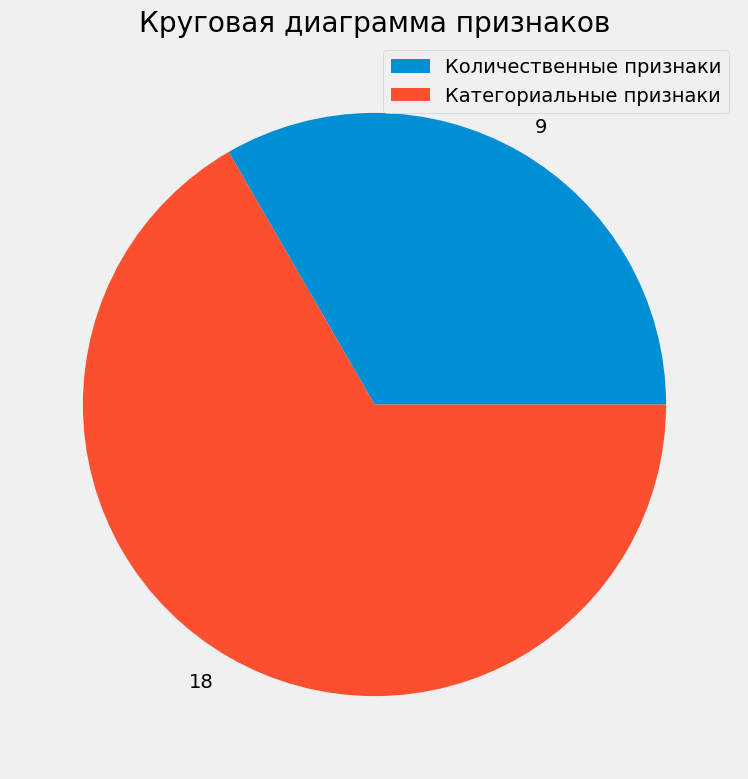

In [7]:
num_cols = [col for col in train.columns if train[col].nunique() > 10 and col != 'id']
cat_cols = [col for col in train.columns if train[col].nunique() <= 10 and col != 'outcome']
target = 'outcome'

plt.figure(figsize=(9,9))
plt.pie([len(num_cols), len(cat_cols)], labels = [len(num_cols), len(cat_cols)])
plt.legend(['Количественные признаки', 'Категориальные признаки'])
plt.title('Круговая диаграмма признаков')
plt.show()

### Feature Distribution of Categorical Features

Теперь взглянем на распределение категориальных признаков с учетом состояния лошади

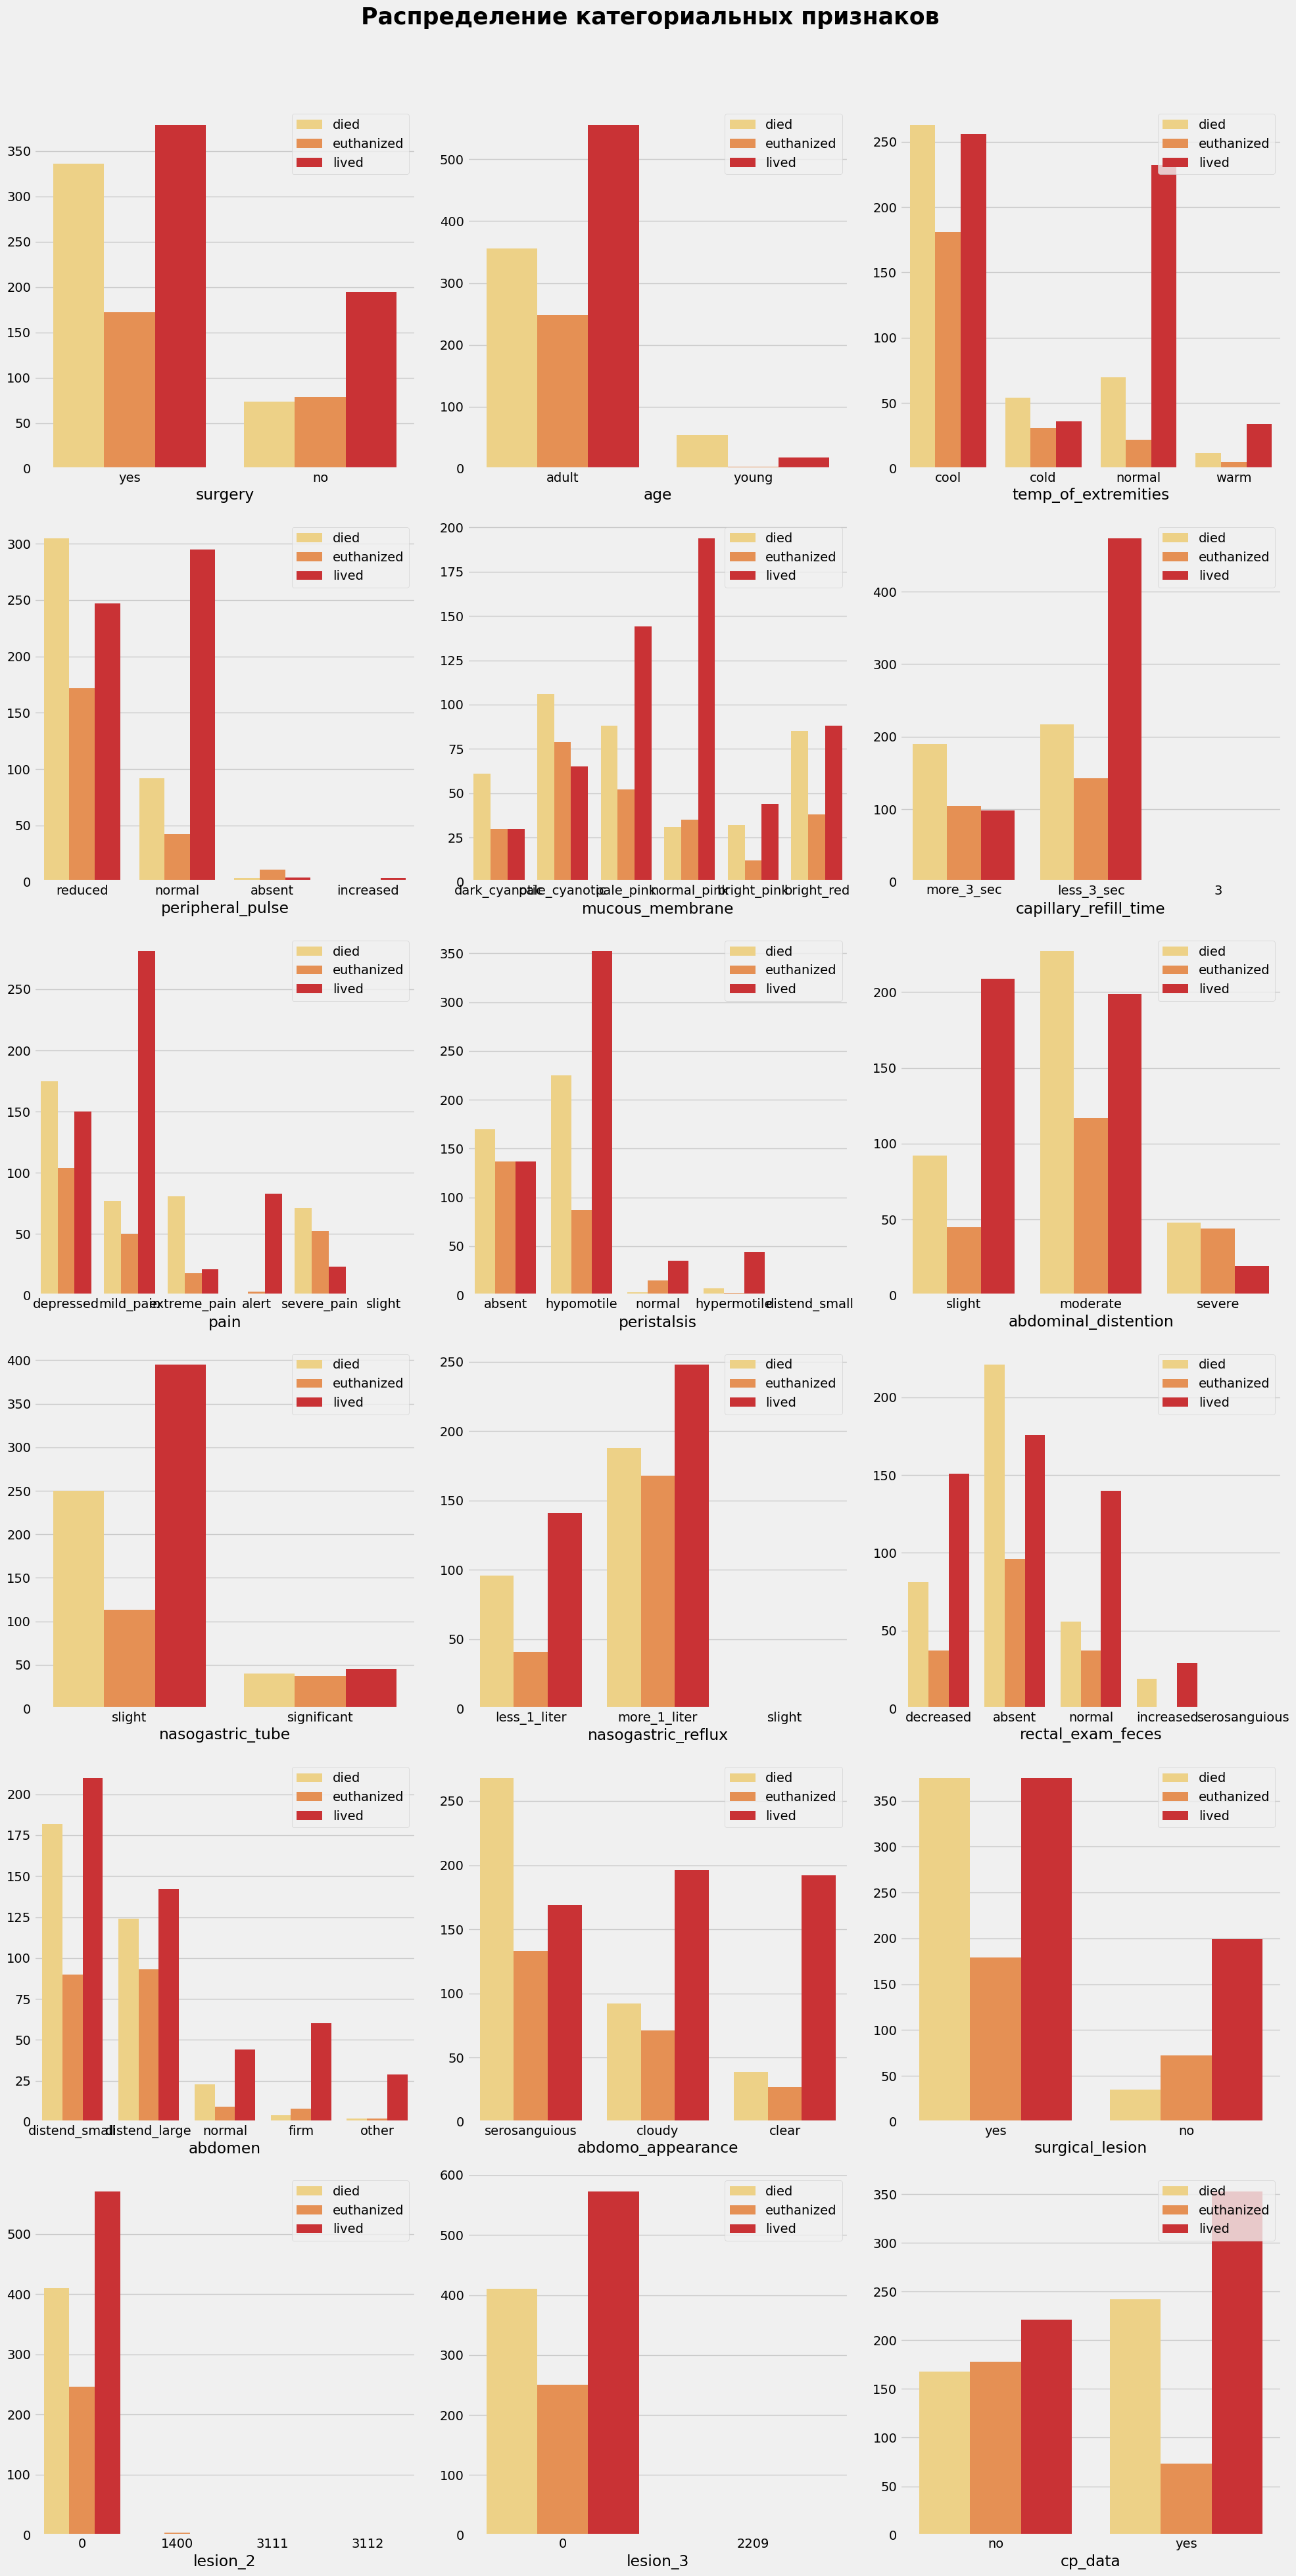

In [ ]:
plot_cat_features(data=train, features=cat_cols, target=target, NCOLS=3)

Выводы:


*   Очень много здоровых лошадей при нормальном перефирическом кровообращении (***temp_of_extremities***)  
*   Отсутствие кала (***rectal_exam_feces***) было у многих почивших лошадей, но нельзя это называть причиной их смерти


*   Сильное вздутие (***abdominal_distention***) живота может служить причиной смерти или эвтаназии лошади
*   Если жидкость из брюшной полости (***abdomo_appearance***) серозно-кровянистая, то это говорит о поражении кишечника животного и как видно на графике это может тоже служить причиной смерти лошади





### Feature Distribution of Continious Features

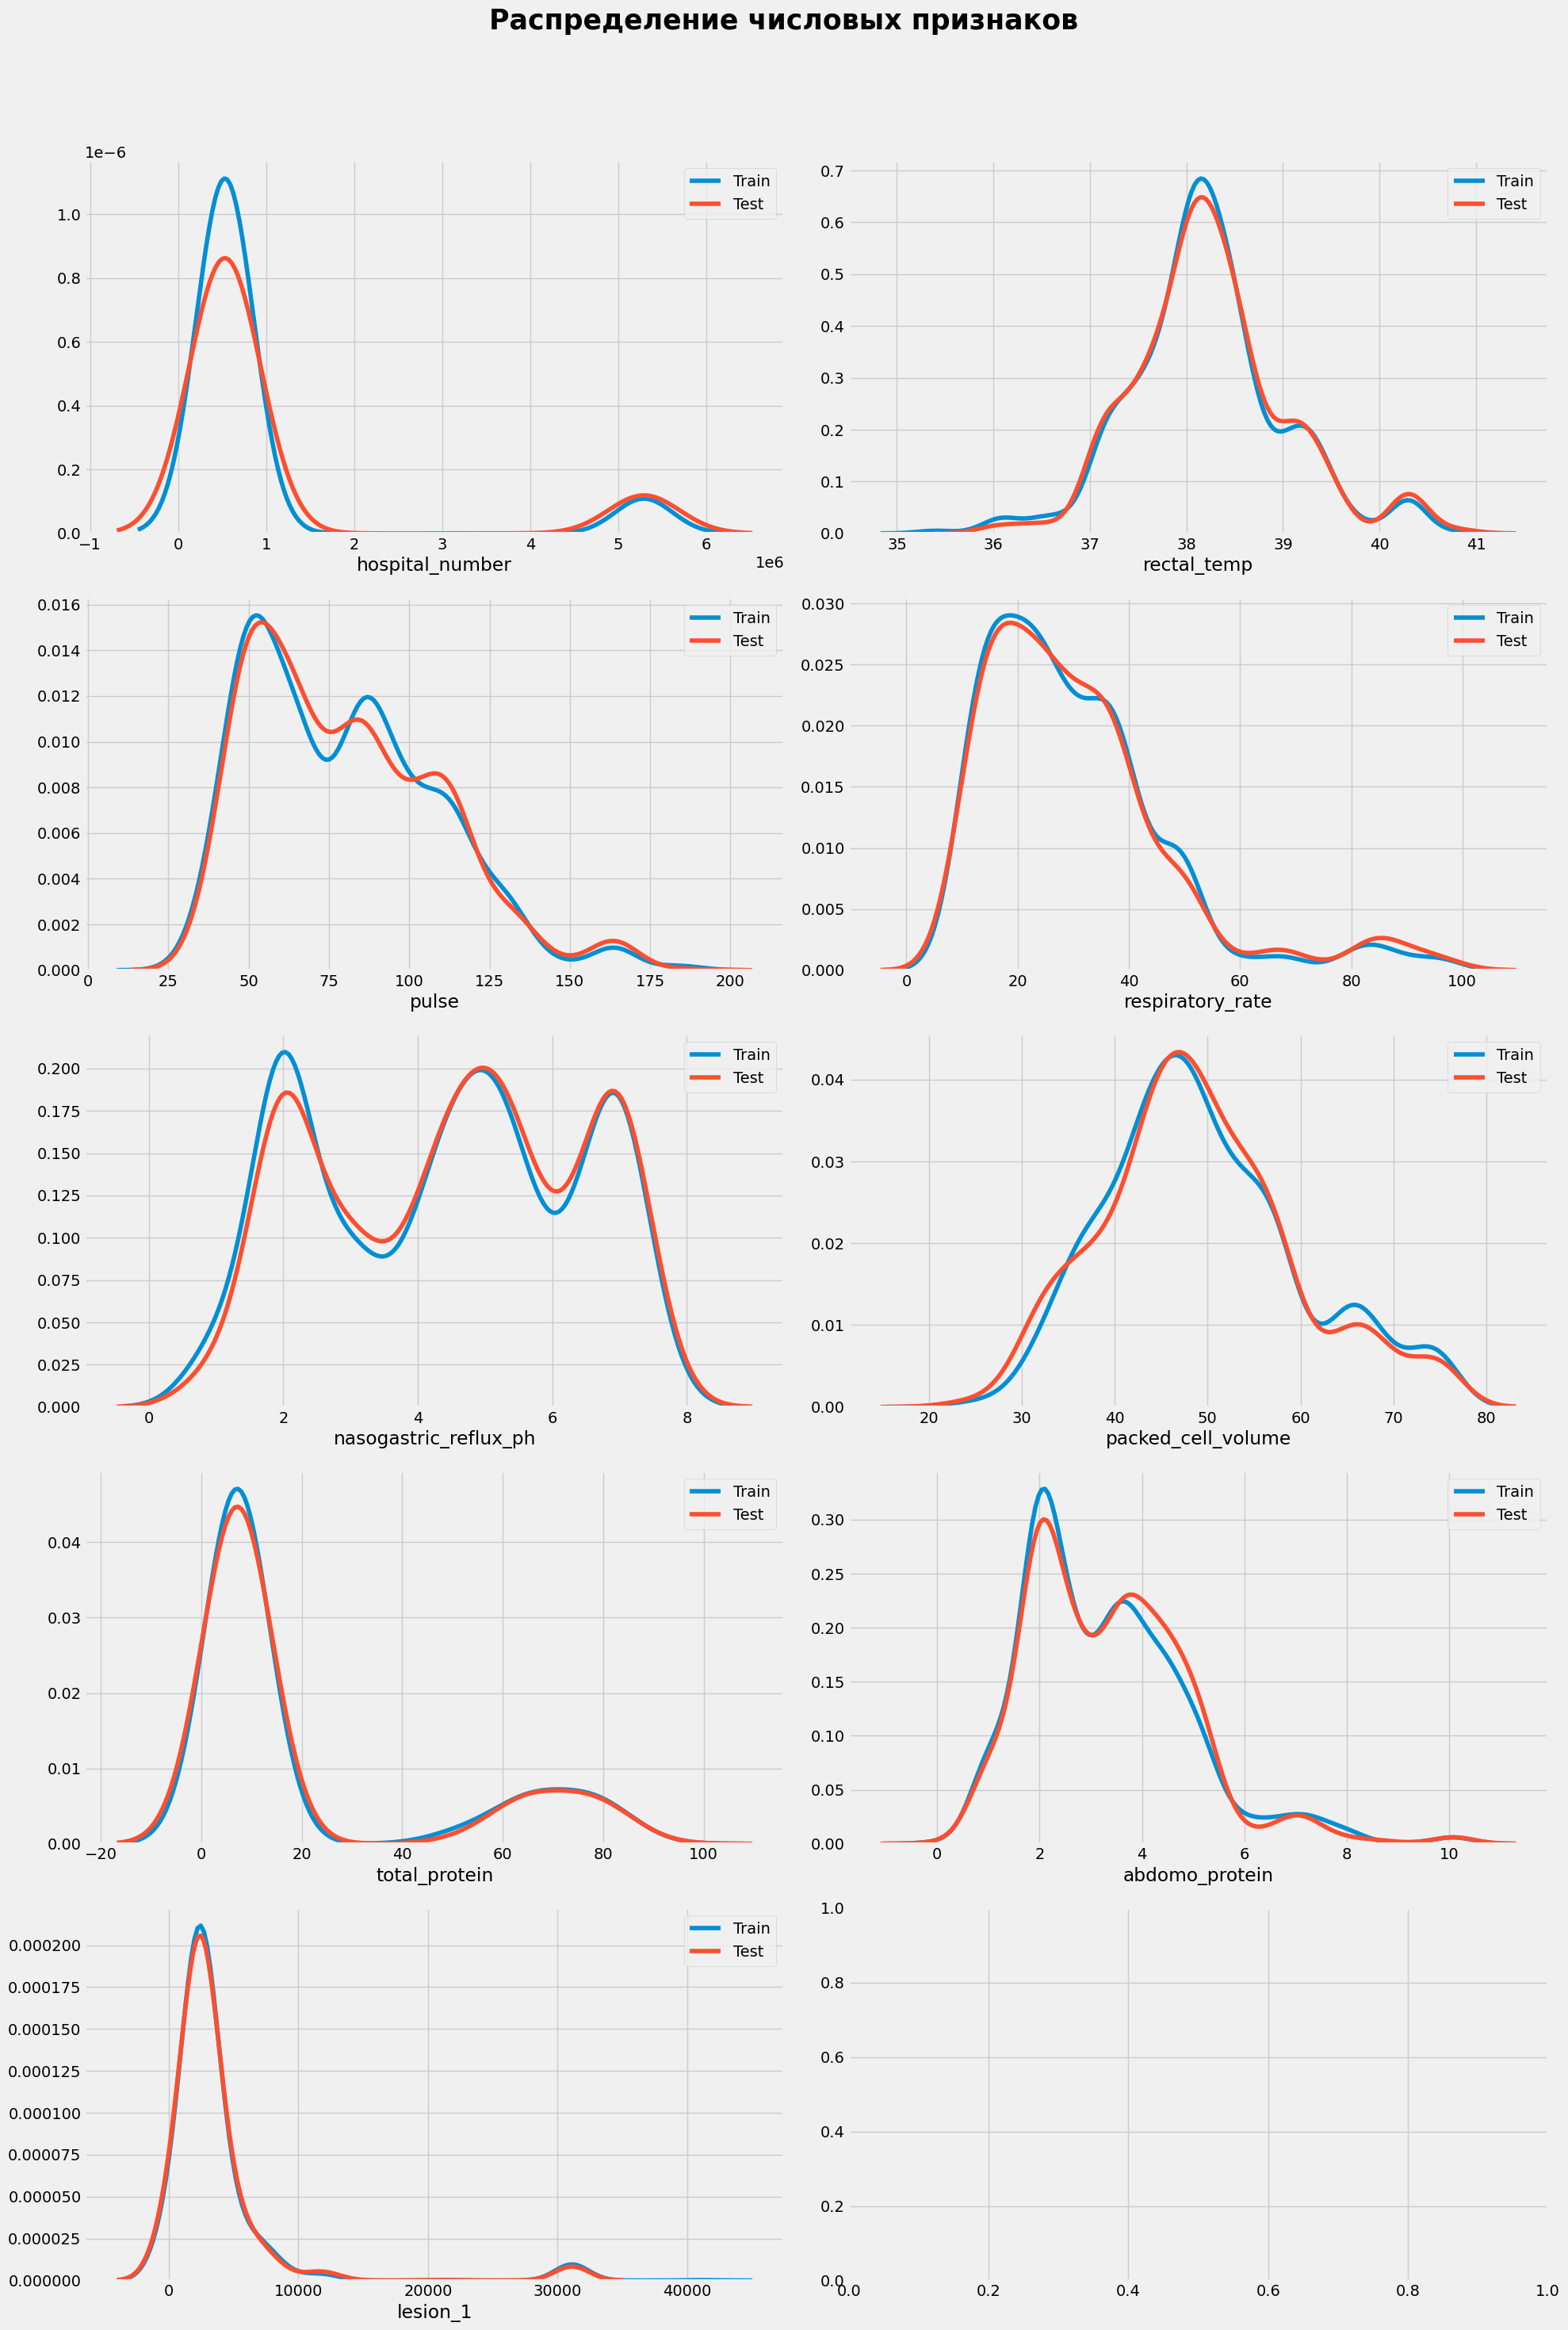

In [ ]:
plot_num_features(train_df=train, test_df=test, features=num_cols, NCOLS=2)

Числовые признаки в тренировочном и тестовом датасете имеют одинаковое распределение

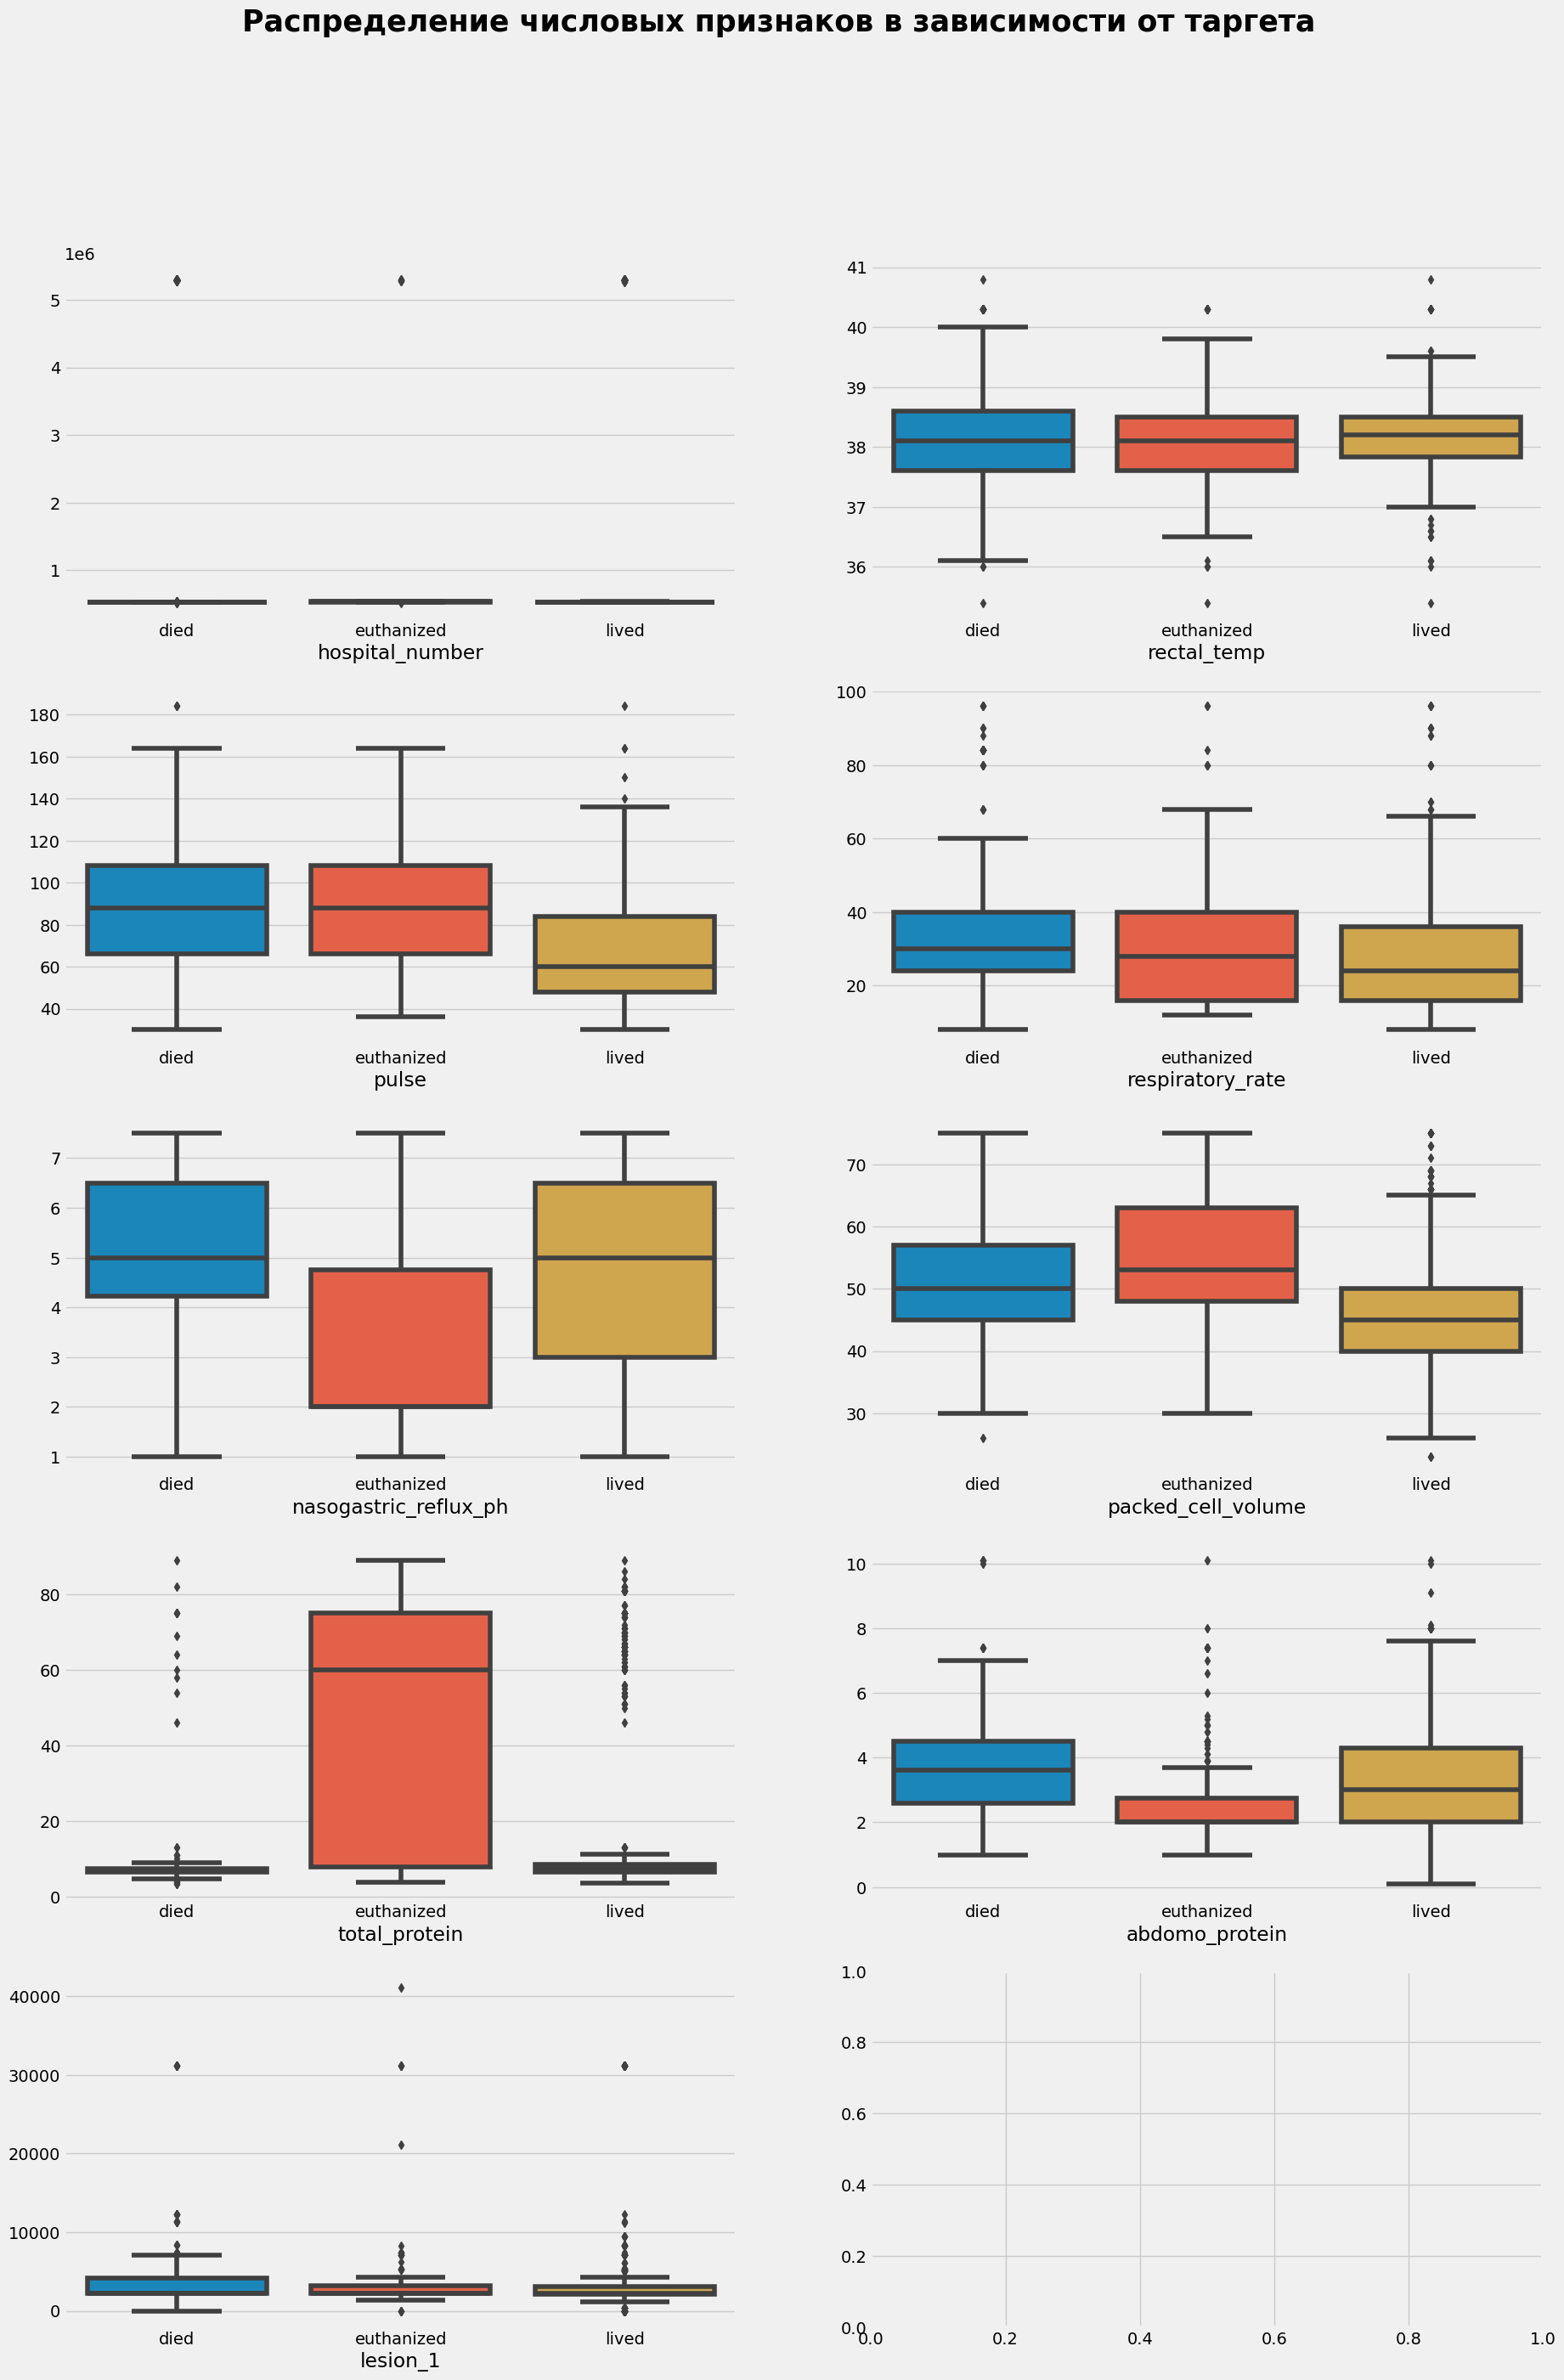

In [ ]:
boxplot_num_features(train_df=train, features=num_cols, NCOLS=2)

Выводы:


*   Относительно низкий показатель пульса (***pulse***) присущ в основном здоровым и живым лошадям
*   Повышенный уровень эритроцитов в крови (***packed_cell_volume***) может наблюдаться при обезвоживании животного или при ухудшении кровообращения


*   Повышенное содержание белка в организме (***total_protein***) тоже говорит об обезвоживании, наблюдается много эвтаназии лошадей с высоким белком






### Target Distribution

In [ ]:
import plotly.express as px
# train[target].value_counts().plot(kind='pie')
px.pie(train, names=target, title='Распределение зависимой переменной', hole=0.4)


Дисбаланса в распределении не наблюдается

## Preprocessing

In [ ]:
test['pain'].value_counts()

depressed       310
mild_pain       255
severe_pain     115
extreme_pain     82
alert            32
moderate          1
Name: pain, dtype: int64

In [ ]:
train['pain'].value_counts()

depressed       429
mild_pain       408
severe_pain     146
extreme_pain    120
alert            87
slight            1
Name: pain, dtype: int64

'slight', 'moderate' - «легкий», «умеренный», сделаем замену 'slight' на 'moderate'

In [ ]:
train['peristalsis'].value_counts()

hypomotile       664
absent           444
normal            53
hypermotile       53
distend_small      1
Name: peristalsis, dtype: int64

"distend_small" можно отнести к нормальной активности кишечника лошади

In [ ]:
train['rectal_exam_feces'].value_counts()

absent           493
decreased        269
normal           233
increased         49
serosanguious      1
Name: rectal_exam_feces, dtype: int64

In [ ]:
train['nasogastric_reflux'].value_counts()

more_1_liter    604
less_1_liter    278
slight            1
Name: nasogastric_reflux, dtype: int64

In [ ]:
test['nasogastric_reflux'].value_counts()

more_1_liter    373
less_1_liter    212
Name: nasogastric_reflux, dtype: int64

In [ ]:
info(train)

размер датасета: (1235, 29)


,data_type,missing_counts,%_missing,number_of_unique,max,min,std,top,first_value
abdomen,object,213,17.246964,5,NaN,NaN,NaN,distend_small,distend_small
rectal_exam_feces,object,190,15.384615,5,NaN,NaN,NaN,absent,decreased
nasogastric_tube,object,80,6.477733,3,NaN,NaN,NaN,slight,slight
peripheral_pulse,object,60,4.858300,4,NaN,NaN,NaN,reduced,reduced
abdomo_appearance,object,48,3.886640,3,NaN,NaN,NaN,serosanguious,serosanguious
pain,object,44,3.562753,6,NaN,NaN,NaN,depressed,depressed
temp_of_extremities,object,39,3.157895,4,NaN,NaN,NaN,cool,cool
abdominal_distention,object,23,1.862348,4,NaN,NaN,NaN,moderate,slight
nasogastric_reflux,object,21,1.700405,4,NaN,NaN,NaN,more_1_liter,less_1_liter
mucous_membrane,object,21,1.700405,6,NaN,NaN,NaN,pale_pink,dark_cyanotic


Энкодинг категориальных переменных, а также работа с пропусками. Стоит отметить, что пропуски содержаться только в категориальных признаках. Будем подставлять моду выборки для каждого признака  

In [8]:
from sklearn.preprocessing import LabelEncoder

def preprocessing(df, le_cols:list, ohe_cols:list):

    le = LabelEncoder()
    for col in le_cols:
        df[col] = le.fit_transform(df[col])

    df = pd.get_dummies(df, columns=ohe_cols)

    df['pain'] = df['pain'].replace('slight', 'moderate')
    df['peristalsis'] = df['peristalsis'].replace('distend_small', 'normal')
    df['rectal_exam_feces'] = df['rectal_exam_feces'].replace('serosanguious', 'absent')
    df['nasogastric_reflux'] = df['nasogastric_reflux'].replace('slight', 'none')

    df['nasogastric_reflux'] = df['nasogastric_reflux'].fillna('none').map({'more_1_liter': 2,
                                                                            'less_1_liter': 1,
                                                                            'none': 0})

    df['nasogastric_tube'] = df['nasogastric_tube'].fillna('none').map({'significant': 2,
                                                                        'slight': 1,
                                                                        'none': 0})

    df['abdomen'] = df['abdomen'].fillna('distend_small').map({'distend_small': 1,
                                                               'distend_large': 2,
                                                               'normal': 3,
                                                               'firm': 4,
                                                               'other': 0})

    df['rectal_exam_feces'] = df['rectal_exam_feces'].fillna('absent').map({'absent': 0,
                                                                            'decreased': 1,
                                                                            'normal': 2,
                                                                            'increased': 3,
                                                                            })

    df['peripheral_pulse'] = df['peripheral_pulse'].fillna('normal').map({'reduced': 0,
                                                                          'normal': 1,
                                                                          'absent': 2,
                                                                          'increased': 3})

    df['abdomo_appearance'] = df['abdomo_appearance'].fillna('serosanguious').map({'serosanguious': 0,
                                                                          'cloudy': 1,
                                                                          'clear': 2})

    df['pain'] = df['pain'].fillna('depressed').map({'depressed': 0,
                                                     'mild_pain': 1,
                                                     'severe_pain': 2,
                                                     'extreme_pain': 3,
                                                     'alert': 4,
                                                     'moderate': 5})

    df['temp_of_extremities'] = df['temp_of_extremities'].fillna('cool').map({'cool': 0,
                                                                              'normal': 1,
                                                                              'cold': 2,
                                                                              'warm': 3})

    df['abdominal_distention'] = df['abdominal_distention'].fillna('none').map({'moderate': 0,
                                                                              'slight': 1,
                                                                              'none': 2,
                                                                              'severe': 3})

    # df['mucous_membrane'] = df['mucous_membrane'].fillna('cool').map({})

    df["peristalsis"] = df["peristalsis"].fillna("hypomotile").map({'hypermotile': 0,
                                                                    'normal': 1,
                                                                    'hypomotile': 2,
                                                                    'absent': 3})

    df["capillary_refill_time"] = df["capillary_refill_time"].fillna("less_3_sec").map({'less_3_sec': 0,
                                                                                        '3': 1,
                                                                                        'more_3_sec': 2})


    return df

In [9]:
train_copy = train.copy()
test_copy = test.copy()

In [10]:
le_cols = ["surgery", "age", "surgical_lesion", "cp_data"]

train_copy = preprocessing(train_copy, le_cols=le_cols, ohe_cols=['mucous_membrane'])
test_copy = preprocessing(test_copy, le_cols=le_cols, ohe_cols=['mucous_membrane'])

In [ ]:
train['outcome'].value_counts()

lived         574
died          410
euthanized    251
Name: outcome, dtype: int64

In [11]:
y_cat = train['outcome'].copy()
train_copy['outcome'] = train_copy['outcome'].map({'lived': 0,
                                         'died' : 1,
                                         'euthanized': 2})

In [ ]:
info(train_copy)

размер датасета: (1235, 34)


,data_type,missing_counts,%_missing,number_of_unique,max,min,std,first_value
id,int64,0,0.0,1235,1234.0,0.0,3.566581e+02,0.0
lesion_3,int64,0,0.0,2,2209.0,0.0,8.885895e+01,0.0
total_protein,float64,0,0.0,83,89.0,3.5,2.667645e+01,8.5
abdomo_appearance,int64,0,0.0,3,2.0,0.0,7.904724e-01,0.0
abdomo_protein,float64,0,0.0,54,10.1,0.1,1.589195e+00,3.4
surgical_lesion,int64,0,0.0,2,1.0,0.0,4.318943e-01,1.0
lesion_1,int64,0,0.0,57,41110.0,0.0,5.436734e+03,2209.0
lesion_2,int64,0,0.0,4,3112.0,0.0,1.937057e+02,0.0
cp_data,int64,0,0.0,2,1.0,0.0,4.985270e-01,0.0
surgery,int64,0,0.0,2,1.0,0.0,4.500496e-01,1.0


### Correlation With All Features

In [12]:
train_copy.drop(columns=['id'], inplace=True)
test_copy.drop(columns=['id'], inplace=True)

In [ ]:
def correlation_view(df, columns:list, title:str):

    f, ax = plt.subplots(figsize=(15,15))

    corr_matrix = df[columns].corr()
    mask = np.zeros_like(corr_matrix)
    mask[np.triu_indices_from(mask)] = True # Возвращает индексы для верхнего треугольника

    sns.heatmap(corr_matrix, annot=False, mask=mask, ax = ax,  cmap="Blues") # PiYG
    ax.set_title(f'{title}', fontsize=15)

    return

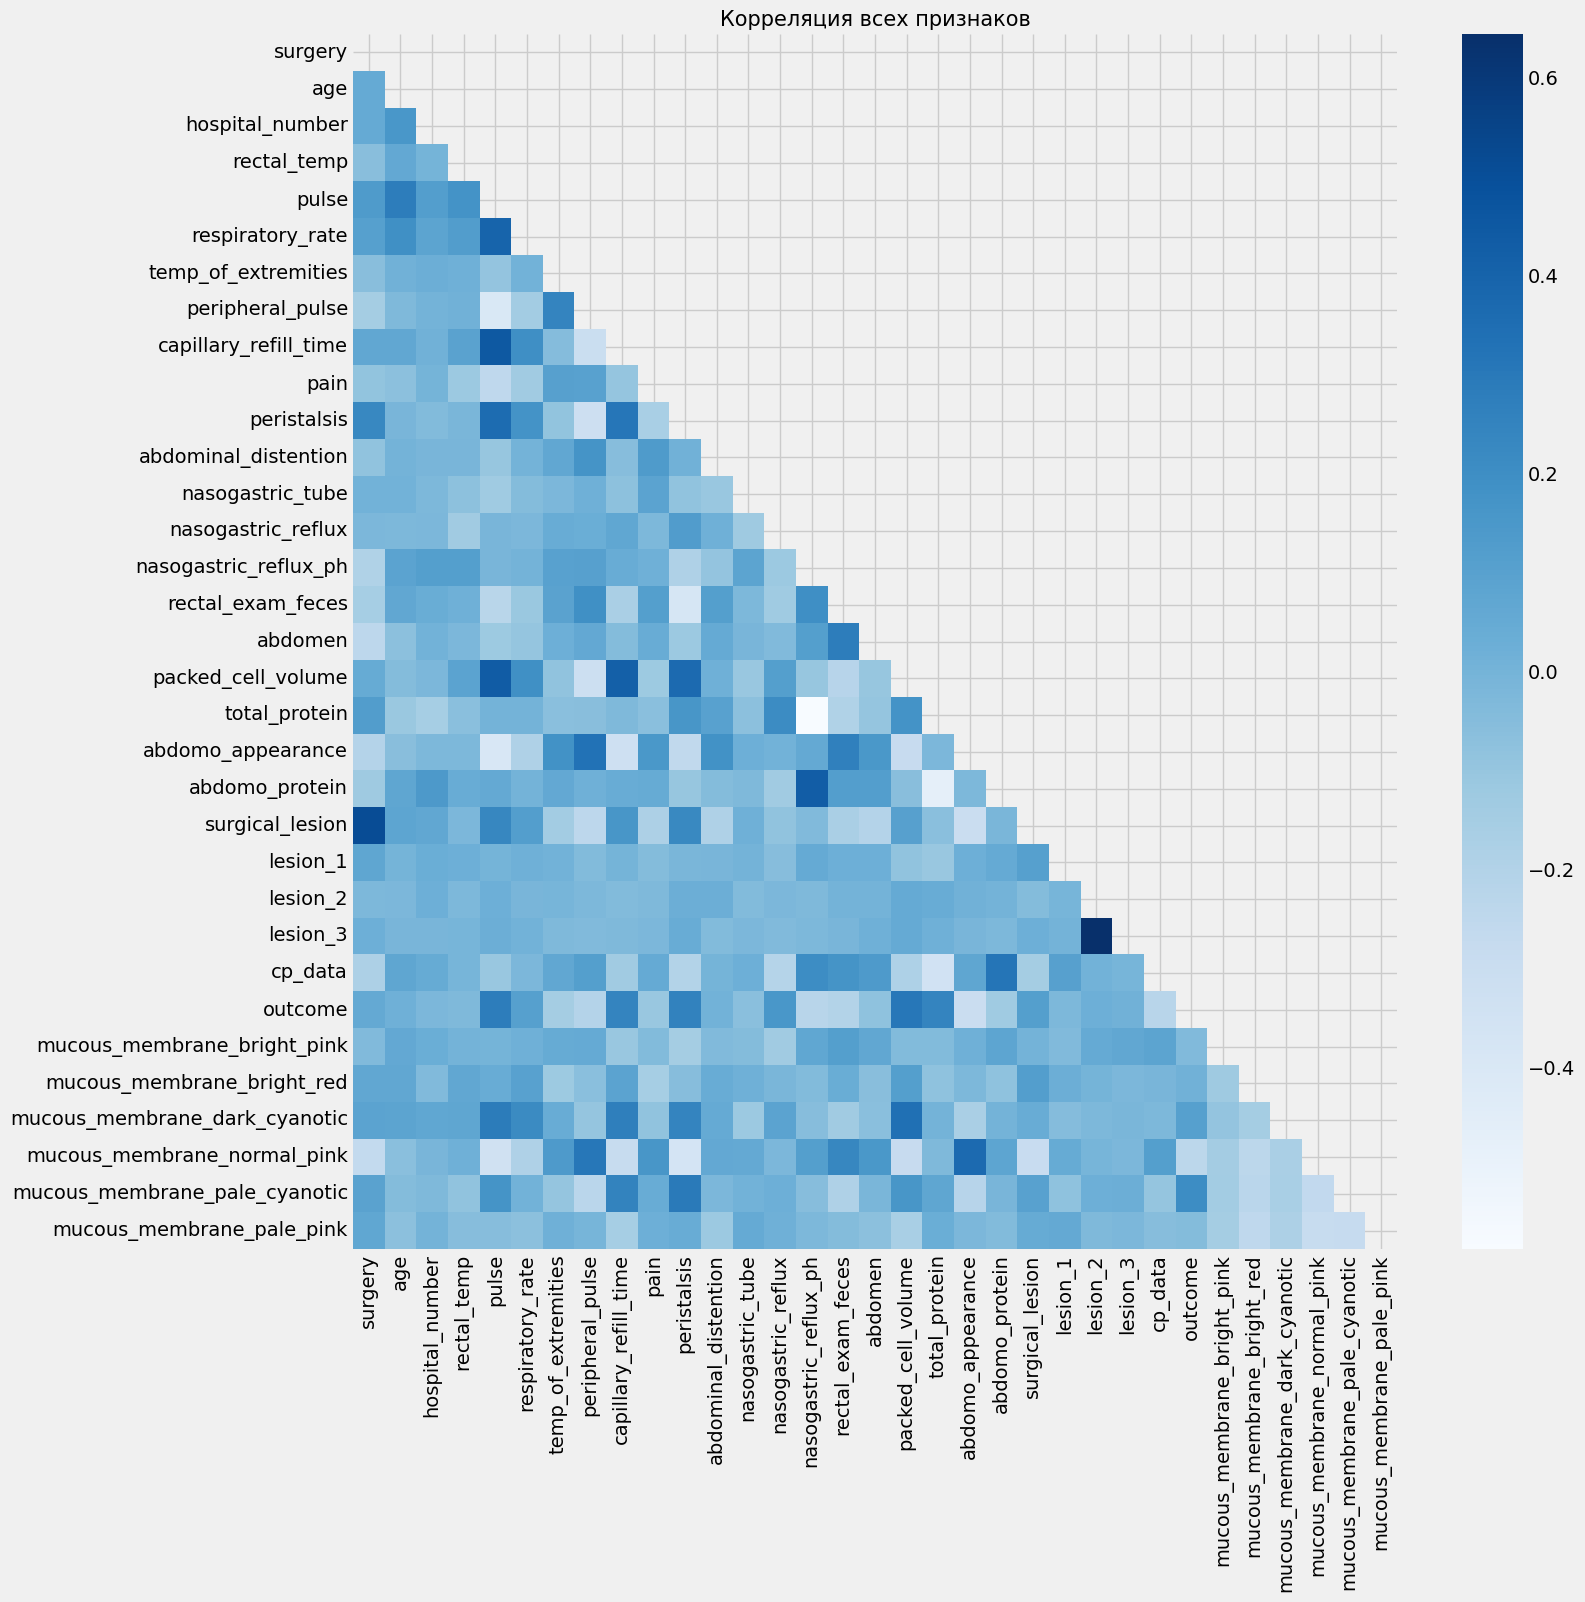

In [ ]:
correlation_view(train_copy, columns=list(train_copy.columns), title='Корреляция всех признаков')

С колонкой, которую надо предсказать, ничего не коррелирует, да и в целом данные относительно линейно независимы друг от друга, в отличие от ***lesion_2*** и ***lesion_3***  

## Обучение

Обучим модель ***lightgbm*** через ***optuna*** на стратифицированной выборке

In [21]:
# light LGBM
from lightgbm import LGBMClassifier as lgb
# Optuna
import optuna

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold

In [14]:
# pip install optuna

In [44]:
RANDOM_STATE = 42
scores = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
X = train_copy.drop(columns=['outcome'])
y = train_copy['outcome']


In [45]:
def objective(trial):
    params = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class" : 3, # кол-во классов в таргете, используется только для мультикласса
        "num_iterations": 1000,
        "verbosity": -1,
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0), # бэггинг признаков для обучения (bagging_fraction*100) % признаков
        "bagging_freq": 1, # через столько итераций будет использован бэггинг
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 100), # макс. кол-во листьев в дереве
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100), # мин кол-во данных в одном листе
    }

    model = lgb(**params,
                random_state=RANDOM_STATE)


    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):

        print(10 * '=', f'FOLD = {fold + 1}', 10 * '=')
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train,  eval_set=[(X_valid, y_valid)])
        preds = model.predict(X_valid)
        f1 = f1_score(y_valid, preds, average='micro')
        # scores.append(f1)

        print(f'FOLD = {fold + 1}, f1_score = {f1:.2f}')

    return f1

In [46]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=False)

[I 2023-09-27 21:17:11,479] A new study created in memory with name: no-name-4ee3f483-162e-42ef-a121-6f46d09c29e0


========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.74
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.69
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.79
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.68
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.72
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.68
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.69
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.73
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.72
========== FOLD = 10 ==========


[I 2023-09-27 21:17:51,688] Trial 0 finished with value: 0.7398373983739838 and parameters: {'bagging_fraction': 0.9208910795739064, 'learning_rate': 0.006195033783355321, 'num_leaves': 42, 'colsample_bytree': 0.9499269684150106, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.7398373983739838.


FOLD = 10, f1_score = 0.74
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.66
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.66
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.77
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.70
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.65
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.65
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.75
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.71
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.72
========== FOLD = 10 ==========


[I 2023-09-27 21:18:02,067] Trial 1 finished with value: 0.7398373983739838 and parameters: {'bagging_fraction': 0.7403759062741921, 'learning_rate': 0.030681130412888887, 'num_leaves': 91, 'colsample_bytree': 0.30938806501582944, 'min_data_in_leaf': 92}. Best is trial 0 with value: 0.7398373983739838.


FOLD = 10, f1_score = 0.74
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.73
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.69
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.80
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.76
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.69
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.66
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.69
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.72
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.74
========== FOLD = 10 ==========


[I 2023-09-27 21:18:17,713] Trial 2 finished with value: 0.7560975609756099 and parameters: {'bagging_fraction': 0.8100914678362803, 'learning_rate': 0.0032874811449224643, 'num_leaves': 87, 'colsample_bytree': 0.23517798835656073, 'min_data_in_leaf': 37}. Best is trial 2 with value: 0.7560975609756099.


FOLD = 10, f1_score = 0.76
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.67
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.68
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.77
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.71
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.65
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.65
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.74
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.70
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.75
========== FOLD = 10 ==========


[I 2023-09-27 21:18:29,088] Trial 3 finished with value: 0.7560975609756099 and parameters: {'bagging_fraction': 0.9258514170420707, 'learning_rate': 0.06435243845956025, 'num_leaves': 84, 'colsample_bytree': 0.18544468383567247, 'min_data_in_leaf': 81}. Best is trial 2 with value: 0.7560975609756099.


FOLD = 10, f1_score = 0.76
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.68
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.64
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.77
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.68
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.63
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.65
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.68
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.69
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.72
========== FOLD = 10 ==========


[I 2023-09-27 21:18:44,814] Trial 4 finished with value: 0.7073170731707317 and parameters: {'bagging_fraction': 0.47220694824388454, 'learning_rate': 0.001448484056968582, 'num_leaves': 16, 'colsample_bytree': 0.590139805149527, 'min_data_in_leaf': 45}. Best is trial 2 with value: 0.7560975609756099.


FOLD = 10, f1_score = 0.71
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.71
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.70
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.79
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.70
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.66
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.69
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.69
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.72
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.73
========== FOLD = 10 ==========


[I 2023-09-27 21:19:07,111] Trial 5 finished with value: 0.7886178861788617 and parameters: {'bagging_fraction': 0.6058111935658124, 'learning_rate': 0.013912944260984678, 'num_leaves': 69, 'colsample_bytree': 0.3606724179939445, 'min_data_in_leaf': 20}. Best is trial 5 with value: 0.7886178861788617.


FOLD = 10, f1_score = 0.79
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.71
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.68
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.77
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.69
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.66
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.63
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.72
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.67
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.76
========== FOLD = 10 ==========


[I 2023-09-27 21:19:16,996] Trial 6 finished with value: 0.7560975609756099 and parameters: {'bagging_fraction': 0.6550605281156956, 'learning_rate': 0.06665106592299881, 'num_leaves': 6, 'colsample_bytree': 0.5308323974174575, 'min_data_in_leaf': 32}. Best is trial 5 with value: 0.7886178861788617.


FOLD = 10, f1_score = 0.76
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.72
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.66
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.78
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.69
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.67
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.70
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.72
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.69
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.76
========== FOLD = 10 ==========


[I 2023-09-27 21:19:35,541] Trial 7 finished with value: 0.7398373983739838 and parameters: {'bagging_fraction': 0.816002627405059, 'learning_rate': 0.09503864072398725, 'num_leaves': 60, 'colsample_bytree': 0.7243920312831735, 'min_data_in_leaf': 26}. Best is trial 5 with value: 0.7886178861788617.


FOLD = 10, f1_score = 0.74
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.70
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.65
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.73
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.69
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.67
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.64
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.72
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.69
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.72
========== FOLD = 10 ==========


[I 2023-09-27 21:19:42,521] Trial 8 finished with value: 0.7398373983739838 and parameters: {'bagging_fraction': 0.40147255194131815, 'learning_rate': 0.038405498195791324, 'num_leaves': 48, 'colsample_bytree': 0.2963505261238383, 'min_data_in_leaf': 97}. Best is trial 5 with value: 0.7886178861788617.


FOLD = 10, f1_score = 0.74
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.72
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.66
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.78
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.72
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.67
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.67
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.71
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.71
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.75
========== FOLD = 10 ==========


[I 2023-09-27 21:19:53,380] Trial 9 finished with value: 0.7642276422764228 and parameters: {'bagging_fraction': 0.43876454814171206, 'learning_rate': 0.00764224720722897, 'num_leaves': 45, 'colsample_bytree': 0.30774198219875776, 'min_data_in_leaf': 60}. Best is trial 5 with value: 0.7886178861788617.


FOLD = 10, f1_score = 0.76
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.66
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.66
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.79
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.75
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.69
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.61
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.68
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.70
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.74
========== FOLD = 10 ==========


[I 2023-09-27 21:20:14,061] Trial 10 finished with value: 0.7560975609756099 and parameters: {'bagging_fraction': 0.5825255911294634, 'learning_rate': 0.017390899139710425, 'num_leaves': 68, 'colsample_bytree': 0.07785511514322452, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.7886178861788617.


FOLD = 10, f1_score = 0.76
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.69
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.66
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.77
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.73
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.66
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.67
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.71
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.69
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.73
========== FOLD = 10 ==========


[I 2023-09-27 21:20:25,409] Trial 11 finished with value: 0.7723577235772358 and parameters: {'bagging_fraction': 0.5282476029569558, 'learning_rate': 0.010716663002928586, 'num_leaves': 33, 'colsample_bytree': 0.3947417216332269, 'min_data_in_leaf': 66}. Best is trial 5 with value: 0.7886178861788617.


FOLD = 10, f1_score = 0.77
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.72
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.67
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.76
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.73
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.64
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.67
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.71
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.69
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.75
========== FOLD = 10 ==========


[I 2023-09-27 21:20:37,307] Trial 12 finished with value: 0.7479674796747967 and parameters: {'bagging_fraction': 0.5489229873691879, 'learning_rate': 0.015360585038944738, 'num_leaves': 22, 'colsample_bytree': 0.42440447714599766, 'min_data_in_leaf': 64}. Best is trial 5 with value: 0.7886178861788617.


FOLD = 10, f1_score = 0.75
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.71
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.69
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.80
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.72
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.68
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.68
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.70
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.74
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.75
========== FOLD = 10 ==========


[I 2023-09-27 21:20:58,135] Trial 13 finished with value: 0.7723577235772358 and parameters: {'bagging_fraction': 0.5567035404036504, 'learning_rate': 0.011591721493405805, 'num_leaves': 28, 'colsample_bytree': 0.421957791447286, 'min_data_in_leaf': 18}. Best is trial 5 with value: 0.7886178861788617.


FOLD = 10, f1_score = 0.77
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.66
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.62
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.74
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.68
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.62
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.65
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.71
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.68
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.70
========== FOLD = 10 ==========


[I 2023-09-27 21:21:06,647] Trial 14 finished with value: 0.7154471544715447 and parameters: {'bagging_fraction': 0.6483242216591415, 'learning_rate': 0.004638207363791841, 'num_leaves': 71, 'colsample_bytree': 0.06363283412185305, 'min_data_in_leaf': 71}. Best is trial 5 with value: 0.7886178861788617.


FOLD = 10, f1_score = 0.72
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.71
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.65
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.77
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.73
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.63
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.65
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.72
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.70
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.72
========== FOLD = 10 ==========


[I 2023-09-27 21:21:18,512] Trial 15 finished with value: 0.7317073170731707 and parameters: {'bagging_fraction': 0.5105059744176941, 'learning_rate': 0.021769798608543438, 'num_leaves': 34, 'colsample_bytree': 0.4189267142511401, 'min_data_in_leaf': 55}. Best is trial 5 with value: 0.7886178861788617.


FOLD = 10, f1_score = 0.73
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.69
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.67
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.77
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.70
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.60
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.67
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.68
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.69
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.76
========== FOLD = 10 ==========


[I 2023-09-27 21:21:28,151] Trial 16 finished with value: 0.7723577235772358 and parameters: {'bagging_fraction': 0.6269797348047683, 'learning_rate': 0.01017759384550945, 'num_leaves': 66, 'colsample_bytree': 0.6328196783541906, 'min_data_in_leaf': 76}. Best is trial 5 with value: 0.7886178861788617.


FOLD = 10, f1_score = 0.77
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.73
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.69
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.77
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.73
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.67
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.67
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.72
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.72
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.74
========== FOLD = 10 ==========


[I 2023-09-27 21:21:41,893] Trial 17 finished with value: 0.7642276422764228 and parameters: {'bagging_fraction': 0.5065537189651043, 'learning_rate': 0.01028092371131908, 'num_leaves': 54, 'colsample_bytree': 0.4596224764941269, 'min_data_in_leaf': 44}. Best is trial 5 with value: 0.7886178861788617.


FOLD = 10, f1_score = 0.76
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.69
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.69
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.78
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.69
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.67
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.65
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.69
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.72
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.76
========== FOLD = 10 ==========


[I 2023-09-27 21:22:12,613] Trial 18 finished with value: 0.7804878048780488 and parameters: {'bagging_fraction': 0.6026674296511688, 'learning_rate': 0.025319342775994184, 'num_leaves': 99, 'colsample_bytree': 0.19177367319870575, 'min_data_in_leaf': 13}. Best is trial 5 with value: 0.7886178861788617.


FOLD = 10, f1_score = 0.78
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.71
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.70
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.78
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.73
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.65
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.66
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.72
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.72
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.73
========== FOLD = 10 ==========


[I 2023-09-27 21:22:39,867] Trial 19 finished with value: 0.7560975609756099 and parameters: {'bagging_fraction': 0.5983055438760114, 'learning_rate': 0.02698181998483487, 'num_leaves': 77, 'colsample_bytree': 0.15897082585085937, 'min_data_in_leaf': 10}. Best is trial 5 with value: 0.7886178861788617.


FOLD = 10, f1_score = 0.76
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.69
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.69
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.78
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.69
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.69
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.64
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.70
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.71
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.73
========== FOLD = 10 ==========


[I 2023-09-27 21:22:57,868] Trial 20 finished with value: 0.7804878048780488 and parameters: {'bagging_fraction': 0.6836201096232141, 'learning_rate': 0.03797749621238214, 'num_leaves': 98, 'colsample_bytree': 0.13047044226695886, 'min_data_in_leaf': 19}. Best is trial 5 with value: 0.7886178861788617.


FOLD = 10, f1_score = 0.78
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.68
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.69
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.80
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.68
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.68
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.65
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.72
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.70
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.75
========== FOLD = 10 ==========


[I 2023-09-27 21:23:16,770] Trial 21 finished with value: 0.7723577235772358 and parameters: {'bagging_fraction': 0.6947742260251244, 'learning_rate': 0.0460546583856115, 'num_leaves': 99, 'colsample_bytree': 0.12675373211739677, 'min_data_in_leaf': 19}. Best is trial 5 with value: 0.7886178861788617.


FOLD = 10, f1_score = 0.77
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.69
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.69
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.78
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.67
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.67
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.64
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.67
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.72
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.75
========== FOLD = 10 ==========


[I 2023-09-27 21:23:43,601] Trial 22 finished with value: 0.7967479674796748 and parameters: {'bagging_fraction': 0.6851480572861841, 'learning_rate': 0.018544970982609554, 'num_leaves': 99, 'colsample_bytree': 0.1880328451714596, 'min_data_in_leaf': 13}. Best is trial 22 with value: 0.7967479674796748.


FOLD = 10, f1_score = 0.80
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.69
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.73
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.80
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.72
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.67
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.68
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.70
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.74
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.73
========== FOLD = 10 ==========


[I 2023-09-27 21:24:15,751] Trial 23 finished with value: 0.7560975609756099 and parameters: {'bagging_fraction': 0.6197031865718468, 'learning_rate': 0.019586265837058286, 'num_leaves': 79, 'colsample_bytree': 0.21889688727341491, 'min_data_in_leaf': 10}. Best is trial 22 with value: 0.7967479674796748.


FOLD = 10, f1_score = 0.76
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.66
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.68
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.78
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.71
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.67
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.65
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.69
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.71
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.73
========== FOLD = 10 ==========


[I 2023-09-27 21:24:37,088] Trial 24 finished with value: 0.7886178861788617 and parameters: {'bagging_fraction': 0.7313361146390439, 'learning_rate': 0.023364564051015512, 'num_leaves': 94, 'colsample_bytree': 0.2513278785973313, 'min_data_in_leaf': 23}. Best is trial 22 with value: 0.7967479674796748.


FOLD = 10, f1_score = 0.79
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.69
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.69
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.78
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.71
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.64
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.67
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.70
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.71
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.72
========== FOLD = 10 ==========


[I 2023-09-27 21:24:54,627] Trial 25 finished with value: 0.7886178861788617 and parameters: {'bagging_fraction': 0.734745039301647, 'learning_rate': 0.014796709979885199, 'num_leaves': 87, 'colsample_bytree': 0.2628308062559322, 'min_data_in_leaf': 29}. Best is trial 22 with value: 0.7967479674796748.


FOLD = 10, f1_score = 0.79
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.72
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.69
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.78
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.73
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.66
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.67
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.71
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.72
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.74
========== FOLD = 10 ==========


[I 2023-09-27 21:25:10,759] Trial 26 finished with value: 0.7723577235772358 and parameters: {'bagging_fraction': 0.7239551155855224, 'learning_rate': 0.015536599795642656, 'num_leaves': 77, 'colsample_bytree': 0.32230188903639556, 'min_data_in_leaf': 37}. Best is trial 22 with value: 0.7967479674796748.


FOLD = 10, f1_score = 0.77
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.70
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.70
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.78
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.70
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.65
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.67
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.72
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.73
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.75
========== FOLD = 10 ==========


[I 2023-09-27 21:25:33,176] Trial 27 finished with value: 0.7642276422764228 and parameters: {'bagging_fraction': 0.7710125744999017, 'learning_rate': 0.02355685922599121, 'num_leaves': 91, 'colsample_bytree': 0.3539720570066377, 'min_data_in_leaf': 25}. Best is trial 22 with value: 0.7967479674796748.


FOLD = 10, f1_score = 0.76
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.71
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.72
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.78
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.71
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.65
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.66
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.71
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.74
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.76
========== FOLD = 10 ==========


[I 2023-09-27 21:26:21,013] Trial 28 finished with value: 0.7642276422764228 and parameters: {'bagging_fraction': 0.6766639846352077, 'learning_rate': 0.014469560569073866, 'num_leaves': 91, 'colsample_bytree': 0.238396303663034, 'min_data_in_leaf': 4}. Best is trial 22 with value: 0.7967479674796748.


FOLD = 10, f1_score = 0.76
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.71
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.71
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.79
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.71
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.68
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.64
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.69
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.75
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.74
========== FOLD = 10 ==========


[I 2023-09-27 21:26:52,775] Trial 29 finished with value: 0.7723577235772358 and parameters: {'bagging_fraction': 0.8073508583949527, 'learning_rate': 0.00825124877869973, 'num_leaves': 59, 'colsample_bytree': 0.34198196054605723, 'min_data_in_leaf': 14}. Best is trial 22 with value: 0.7967479674796748.


FOLD = 10, f1_score = 0.77
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.72
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.70
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.80
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.73
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.69
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.65
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.70
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.72
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.74
========== FOLD = 10 ==========


[I 2023-09-27 21:27:09,269] Trial 30 finished with value: 0.7317073170731707 and parameters: {'bagging_fraction': 0.8677071777958756, 'learning_rate': 0.0060885687023957144, 'num_leaves': 75, 'colsample_bytree': 0.9790865691358723, 'min_data_in_leaf': 46}. Best is trial 22 with value: 0.7967479674796748.


FOLD = 10, f1_score = 0.73
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.68
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.69
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.79
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.72
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.63
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.65
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.68
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.71
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.72
========== FOLD = 10 ==========


[I 2023-09-27 21:27:28,635] Trial 31 finished with value: 0.8048780487804877 and parameters: {'bagging_fraction': 0.7229289155063557, 'learning_rate': 0.019216096927346507, 'num_leaves': 84, 'colsample_bytree': 0.26101290009453454, 'min_data_in_leaf': 28}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.80
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.69
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.71
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.79
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.68
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.68
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.67
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.69
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.72
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.72
========== FOLD = 10 ==========


[I 2023-09-27 21:27:54,305] Trial 32 finished with value: 0.8048780487804877 and parameters: {'bagging_fraction': 0.990954418554904, 'learning_rate': 0.03053306168961217, 'num_leaves': 83, 'colsample_bytree': 0.2532989852321829, 'min_data_in_leaf': 22}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.80
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.68
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.69
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.78
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.69
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.67
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.65
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.69
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.71
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.72
========== FOLD = 10 ==========


[I 2023-09-27 21:28:13,716] Trial 33 finished with value: 0.7804878048780488 and parameters: {'bagging_fraction': 0.9804054090315864, 'learning_rate': 0.031959783872951446, 'num_leaves': 83, 'colsample_bytree': 0.27262556351244877, 'min_data_in_leaf': 37}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.78
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.70
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.72
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.79
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.71
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.65
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.67
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.70
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.72
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.75
========== FOLD = 10 ==========


[I 2023-09-27 21:28:31,006] Trial 34 finished with value: 0.7642276422764228 and parameters: {'bagging_fraction': 0.983513940954227, 'learning_rate': 0.019268991862635757, 'num_leaves': 83, 'colsample_bytree': 0.16838109009899752, 'min_data_in_leaf': 34}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.76
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.72
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.72
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.77
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.72
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.65
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.66
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.70
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.74
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.74
========== FOLD = 10 ==========


[I 2023-09-27 21:29:06,877] Trial 35 finished with value: 0.7642276422764228 and parameters: {'bagging_fraction': 0.9221841397744055, 'learning_rate': 0.02864288730401606, 'num_leaves': 65, 'colsample_bytree': 0.22140403338301623, 'min_data_in_leaf': 8}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.76
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.71
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.70
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.77
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.72
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.65
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.67
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.71
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.74
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.75
========== FOLD = 10 ==========


[I 2023-09-27 21:29:34,606] Trial 36 finished with value: 0.7560975609756099 and parameters: {'bagging_fraction': 0.7685619153613463, 'learning_rate': 0.013231319516831347, 'num_leaves': 72, 'colsample_bytree': 0.3648824847091483, 'min_data_in_leaf': 17}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.76
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.69
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.70
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.78
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.71
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.65
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.67
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.71
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.72
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.72
========== FOLD = 10 ==========


[I 2023-09-27 21:29:53,787] Trial 37 finished with value: 0.7886178861788617 and parameters: {'bagging_fraction': 0.8700671105116712, 'learning_rate': 0.018874295212336436, 'num_leaves': 87, 'colsample_bytree': 0.28985522442110595, 'min_data_in_leaf': 31}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.79
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.69
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.70
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.82
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.69
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.65
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.67
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.74
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.71
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.74
========== FOLD = 10 ==========


[I 2023-09-27 21:30:05,889] Trial 38 finished with value: 0.7560975609756099 and parameters: {'bagging_fraction': 0.6639054020119376, 'learning_rate': 0.05604299376369999, 'num_leaves': 81, 'colsample_bytree': 0.128378844499276, 'min_data_in_leaf': 42}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.76
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.69
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.69
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.81
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.69
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.69
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.63
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.71
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.72
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.76
========== FOLD = 10 ==========


[I 2023-09-27 21:30:24,989] Trial 39 finished with value: 0.7967479674796748 and parameters: {'bagging_fraction': 0.7040029953422142, 'learning_rate': 0.03326147044187, 'num_leaves': 61, 'colsample_bytree': 0.20581810894810706, 'min_data_in_leaf': 24}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.80
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.70
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.69
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.75
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.73
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.65
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.66
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.73
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.72
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.75
========== FOLD = 10 ==========


[I 2023-09-27 21:30:35,031] Trial 40 finished with value: 0.7479674796747967 and parameters: {'bagging_fraction': 0.713611573101458, 'learning_rate': 0.038295877713166844, 'num_leaves': 60, 'colsample_bytree': 0.0898502873517526, 'min_data_in_leaf': 51}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.75
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.70
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.70
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.81
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.69
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.66
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.68
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.70
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.72
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.75
========== FOLD = 10 ==========


[I 2023-09-27 21:30:51,532] Trial 41 finished with value: 0.7723577235772358 and parameters: {'bagging_fraction': 0.6417643932106301, 'learning_rate': 0.03347150023605136, 'num_leaves': 55, 'colsample_bytree': 0.2186035840565347, 'min_data_in_leaf': 26}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.77
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.69
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.69
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.79
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.69
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.66
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.63
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.72
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.72
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.75
========== FOLD = 10 ==========


[I 2023-09-27 21:31:11,923] Trial 42 finished with value: 0.7642276422764228 and parameters: {'bagging_fraction': 0.7012626493581211, 'learning_rate': 0.04869096472847018, 'num_leaves': 93, 'colsample_bytree': 0.18673087253634144, 'min_data_in_leaf': 23}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.76
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.72
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.69
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.78
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.72
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.69
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.66
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.70
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.75
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.76
========== FOLD = 10 ==========


[I 2023-09-27 21:31:49,984] Trial 43 finished with value: 0.7479674796747967 and parameters: {'bagging_fraction': 0.6530266714033657, 'learning_rate': 0.025915761561040643, 'num_leaves': 64, 'colsample_bytree': 0.30943141756641085, 'min_data_in_leaf': 1}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.75
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.66
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.69
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.80
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.69
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.67
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.66
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.67
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.70
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.73
========== FOLD = 10 ==========


[I 2023-09-27 21:32:13,582] Trial 44 finished with value: 0.7723577235772358 and parameters: {'bagging_fraction': 0.7667237322246916, 'learning_rate': 0.07493270383252566, 'num_leaves': 72, 'colsample_bytree': 0.26112747639715644, 'min_data_in_leaf': 14}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.77
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.71
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.69
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.79
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.73
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.67
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.68
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.72
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.72
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.74
========== FOLD = 10 ==========


[I 2023-09-27 21:32:29,491] Trial 45 finished with value: 0.7723577235772358 and parameters: {'bagging_fraction': 0.5728653854283644, 'learning_rate': 0.012583589278091011, 'num_leaves': 47, 'colsample_bytree': 0.349206130192175, 'min_data_in_leaf': 29}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.77
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.69
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.71
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.80
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.70
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.68
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.66
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.68
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.74
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.75
========== FOLD = 10 ==========


[I 2023-09-27 21:32:50,728] Trial 46 finished with value: 0.7886178861788617 and parameters: {'bagging_fraction': 0.6727429538619585, 'learning_rate': 0.01965122122512912, 'num_leaves': 87, 'colsample_bytree': 0.2964039676121823, 'min_data_in_leaf': 20}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.79
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.70
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.73
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.77
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.71
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.65
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.66
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.70
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.72
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.75
========== FOLD = 10 ==========


[I 2023-09-27 21:33:29,472] Trial 47 finished with value: 0.7479674796747967 and parameters: {'bagging_fraction': 0.620070811409353, 'learning_rate': 0.03192784053891457, 'num_leaves': 69, 'colsample_bytree': 0.38402801793076885, 'min_data_in_leaf': 5}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.75
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.68
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.72
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.78
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.73
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.69
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.67
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.72
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.73
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.75
========== FOLD = 10 ==========


[I 2023-09-27 21:33:44,899] Trial 48 finished with value: 0.7967479674796748 and parameters: {'bagging_fraction': 0.6957264051268683, 'learning_rate': 0.012448947961605717, 'num_leaves': 39, 'colsample_bytree': 0.20054461274480034, 'min_data_in_leaf': 34}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.80
========== FOLD = 1 ==========
FOLD = 1, f1_score = 0.69
========== FOLD = 2 ==========
FOLD = 2, f1_score = 0.68
========== FOLD = 3 ==========
FOLD = 3, f1_score = 0.78
========== FOLD = 4 ==========
FOLD = 4, f1_score = 0.73
========== FOLD = 5 ==========
FOLD = 5, f1_score = 0.69
========== FOLD = 6 ==========
FOLD = 6, f1_score = 0.64
========== FOLD = 7 ==========
FOLD = 7, f1_score = 0.73
========== FOLD = 8 ==========
FOLD = 8, f1_score = 0.69
========== FOLD = 9 ==========
FOLD = 9, f1_score = 0.76
========== FOLD = 10 ==========


[I 2023-09-27 21:33:54,199] Trial 49 finished with value: 0.7804878048780488 and parameters: {'bagging_fraction': 0.6976964383650665, 'learning_rate': 0.016825384361776382, 'num_leaves': 43, 'colsample_bytree': 0.06084514764932017, 'min_data_in_leaf': 36}. Best is trial 31 with value: 0.8048780487804877.


FOLD = 10, f1_score = 0.78


In [47]:
print('Best hyperparameters:', study.best_params)
print('Best F1_score:', study.best_value)

Best hyperparameters: {'bagging_fraction': 0.7229289155063557, 'learning_rate': 0.019216096927346507, 'num_leaves': 84, 'colsample_bytree': 0.26101290009453454, 'min_data_in_leaf': 28}
Best F1_score: 0.8048780487804877


## Предсказание

In [50]:
best_model = lgb(**study.best_params)
best_model.fit(X, y)
preds = best_model.predict(test_copy)

[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] bagging_fraction is set=0.7229289155063557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7229289155063557
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] bagging_fraction is set=0.7229289155063557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7229289155063557
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 1235, number of used features: 30
[LightGBM] [Info] Start training from score -0.766197
[LightGBM] [Info] Start training from score -1.102669
[LightGBM] [Info] Start training from score -1.593373
[LightGBM]

In [51]:
submission['outcome'] = preds
submission['outcome'] = submission['outcome'].map({0 : 'lived',
                                                   1 : 'died',
                                                   2 : 'euthanized'})

submission.to_csv("lgb-subs_v2.csv",index=False)
submission.head()

,id,outcome
0,1235,lived
1,1236,died
2,1237,lived
3,1238,euthanized
4,1239,lived


## Обучение на всех данных

In [54]:
origin = pd.read_csv('drive/MyDrive/Machine Learning projects/Playground Series/Season 3, Episode 22/horse.csv', na_values="None")

In [55]:
origin.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,absent,severe,NaN,NaN,NaN,decreased,distend_large,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,absent,slight,NaN,NaN,NaN,absent,other,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,NaN,NaN,NaN,normal,normal,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,none,less_1_liter,5.0,decreased,NaN,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


In [57]:
origin_copy = origin.copy()
origin_copy = preprocessing(origin_copy, le_cols=le_cols, ohe_cols=['mucous_membrane'])

In [58]:
X_origin = origin_copy.drop(columns=['outcome'])
y_origin = origin_copy['outcome']

In [59]:
X_train = pd.concat([X, X_origin], ignore_index=True)
y_train = pd.concat([y, y_origin], ignore_index=True)

In [61]:
# from lightgbm.sklearn import LGBMClassifier
best_model = lgb(**study.best_params)
best_model.fit(X_train, y_train)
preds = best_model.predict(test_copy)


ValueError: ignored

In [62]:
info(origin)

размер датасета: (299, 28)


,data_type,missing_counts,%_missing,number_of_unique,max,min,std,first_value
nasogastric_reflux_ph,float64,246,82.274247,20,7.5,1.0,1.982311,NaN
abdomo_protein,float64,198,66.220736,37,10.1,0.1,1.967947,NaN
abdomo_appearance,object,165,55.183946,3,NaN,NaN,NaN,NaN
abdomen,object,118,39.464883,5,NaN,NaN,NaN,distend_large
nasogastric_reflux,object,106,35.451505,3,NaN,NaN,NaN,NaN
nasogastric_tube,object,104,34.782609,3,NaN,NaN,NaN,NaN
rectal_exam_feces,object,102,34.113712,4,NaN,NaN,NaN,decreased
peripheral_pulse,object,69,23.076923,4,NaN,NaN,NaN,reduced
rectal_temp,float64,60,20.066890,40,40.8,35.4,0.733744,38.5
respiratory_rate,float64,58,19.397993,40,96.0,8.0,17.666102,28.0


In [65]:
X_train.isna().sum()

surgery                            0
age                                0
hospital_number                    0
rectal_temp                       60
pulse                             24
respiratory_rate                  58
temp_of_extremities                0
peripheral_pulse                   0
capillary_refill_time              0
pain                               0
peristalsis                        0
abdominal_distention               0
nasogastric_tube                   0
nasogastric_reflux                 0
nasogastric_reflux_ph            246
rectal_exam_feces                  0
abdomen                            0
packed_cell_volume                29
total_protein                     33
abdomo_appearance                  0
abdomo_protein                   198
surgical_lesion                    0
lesion_1                           0
lesion_2                           0
lesion_3                           0
cp_data                            0
mucous_membrane_bright_pink        0
m